**Import Required Libraries**

In [1]:
import torch     
from torch import Tensor                  
import torch.nn as nn                 
import torch.optim as optim              
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict
np.random.seed(1234)

In [2]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())
    

cpu


Load the training data from numpy

In [3]:
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
y_train=d["X"][1].astype(np.float32) #output locations (100,1)
u_train = d["X"][0].astype(np.float32) # input functions (150,100)
s_train = d["y"].astype(np.float32) # output functions (150,100)

**Define Network Archietecture**

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        #define your sequential model here with activations 
        super(DNN, self).__init__()
        self.layers = nn.Sequential()
        for i in range(1, len(layers)):
            self.layers.add_module(f'linear_{i}', nn.Linear(layers[i-1], layers[i]))
            self.layers.add_module(f'Tanh_{i}', nn.Tanh())
        print(self.layers)    
                
                
    def forward(self, x): #forward pass
        out = self.layers(x)
        return out   

**The DeepONet Archietecture**

In [5]:
class PI_DeepONet():
    def __init__(self, branch_layers, trunk_layers,u_train, y_train, s_train):
        
        self.u_train = torch.Tensor(u_train).to(device)  # Convert u_train to torch tensor
        self.y_train = torch.Tensor(y_train).to(device)  # Convert y_train to torch tensor
        self.s_train = torch.Tensor(s_train).to(device)  # Convert s_train to torch tensor
        
        
        self.branch_net = DNN(branch_layers).to(device)  # The branch Network

        self.trunk_net = DNN(trunk_layers).to(device)    # The trunk Network
        
        branch_params = list(self.branch_net.parameters())               #extract the network Parameters in list format
        trunk_params =   list(self.trunk_net.parameters()) 
        
        #extract the network Parameters
        params = branch_params+trunk_params
        
        self.optimizer_Adam = torch.optim.Adam(params, lr=0.01)

        self.iter = 0    #initiate iteration

    
    def operator_net(self,  u, y):    # Define DeepONet architecture
        
        B = self.branch_net(u) #output from branch Network
        T = self.trunk_net(y)  #output from branch Network 
        output = torch.matmul(B, torch.transpose(T,0,1))
        return output
        
    # Define operator loss
    def loss_operator(self, u, y):
        
        pred = self.operator_net(u, y)         # Compute forward pass     
        loss =  torch.mean((self.s_train-pred)**2)        # Compute loss
        return loss

    
    def train(self, nIter):
        
        model_loss=np.array([])
        for epoch in range(nIter):
            loss= self.loss_operator(self.u_train,self.y_train)
             # Backward and optimize
           
            self.optimizer_Adam.zero_grad()
            loss.backward(retain_graph=True) 
            self.optimizer_Adam.step()

            model_loss=np.append(model_loss,loss.detach().numpy())   #get the loss value for each iteration

            if epoch % 10 == 0:
                print(f'Epoch [{epoch}/{nIter}], Loss: {loss.item()}')# print loss and iteration
        
        return model_loss 
             
    # Evaluates predictions at test points  
    def predict_s(self, u_star,y_star):
        u_star = torch.Tensor(u_star).to(device)
        y_star = torch.Tensor(y_star).to(device)
        s = self.operator_net(u_star, y_star)  # Predict
        s = s.detach().cpu().numpy()
        return s

**Train the Model**

In [6]:
# Initialize model

branch_layers = [100, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]

model = PI_DeepONet(branch_layers, trunk_layers,u_train, y_train, s_train)

 
'Neural Network Summary'
print(model)
nIter=2000
loss=model.train(nIter)

Sequential(
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (Tanh_1): Tanh()
  (linear_2): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_2): Tanh()
  (linear_3): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_3): Tanh()
  (linear_4): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_4): Tanh()
  (linear_5): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_5): Tanh()
)
Sequential(
  (linear_1): Linear(in_features=1, out_features=50, bias=True)
  (Tanh_1): Tanh()
  (linear_2): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_2): Tanh()
  (linear_3): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_3): Tanh()
  (linear_4): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_4): Tanh()
  (linear_5): Linear(in_features=50, out_features=50, bias=True)
  (Tanh_5): Tanh()
)
Epoch [0/2000], Loss: 0.3027269244194031
Epoch [10/2000], Loss: 0.25017833709716797
Epoch [20/2000], Loss: 0.05134290084242821
Epoch

Epoch [1580/2000], Loss: 0.0003267248685006052
Epoch [1590/2000], Loss: 9.810642222873867e-05
Epoch [1600/2000], Loss: 0.0002908761380240321
Epoch [1610/2000], Loss: 6.939536979189143e-05
Epoch [1620/2000], Loss: 0.00047916441690176725
Epoch [1630/2000], Loss: 0.0002680417965166271
Epoch [1640/2000], Loss: 0.0005081263952888548
Epoch [1650/2000], Loss: 0.00038192051579244435
Epoch [1660/2000], Loss: 0.000948510249145329
Epoch [1670/2000], Loss: 0.00011108280159533024
Epoch [1680/2000], Loss: 0.002051870571449399
Epoch [1690/2000], Loss: 0.0008444398990832269
Epoch [1700/2000], Loss: 0.0001951684826053679
Epoch [1710/2000], Loss: 0.0001237452233908698
Epoch [1720/2000], Loss: 0.00020748947281390429
Epoch [1730/2000], Loss: 0.0005462492699734867
Epoch [1740/2000], Loss: 0.00019358927966095507
Epoch [1750/2000], Loss: 0.0006864131428301334
Epoch [1760/2000], Loss: 0.0002362924860790372
Epoch [1770/2000], Loss: 0.0006441398872993886
Epoch [1780/2000], Loss: 0.0002713294525165111
Epoch [179

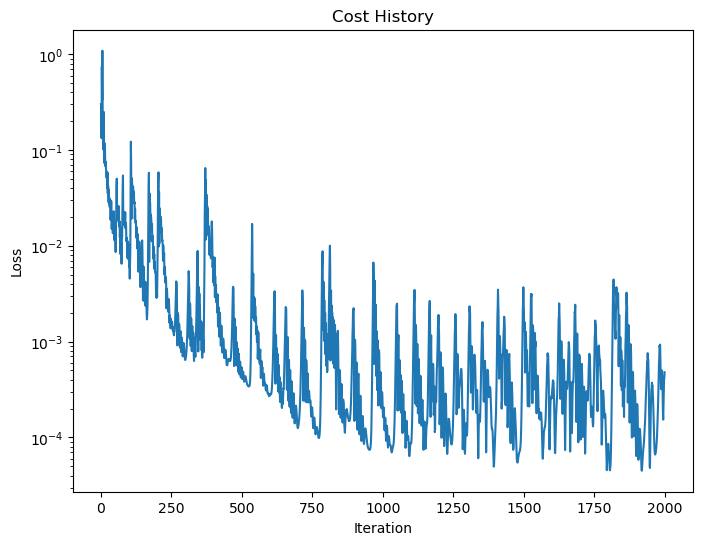

In [7]:
# Plot visualization
plt.figure(figsize=(8, 6))
plt.plot(loss)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost History')
plt.show()

### Apply model on training data and plot the predictions

In [8]:
s_pred_train = model.predict_s(u_train,y_train)

In [9]:
x = np.linspace(0, 1, 100)

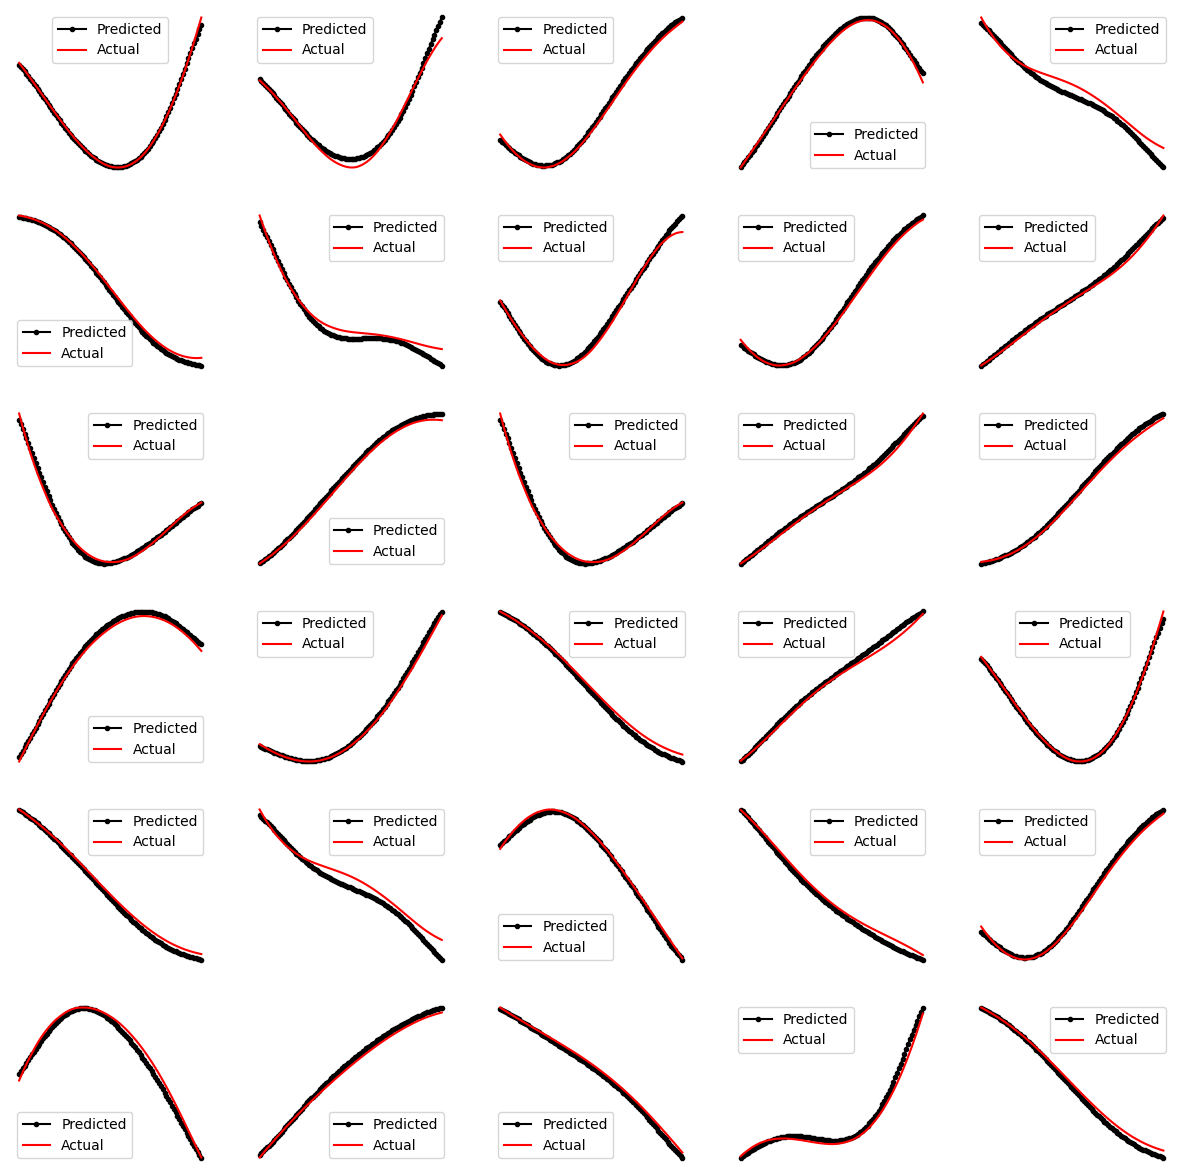

In [10]:
fig = plt.figure(figsize=(15,15))
for i in range(30):  
    r = np.random.choice(100)
    ax = fig.add_subplot(6, 5, i+1)
    ax.plot(x,s_pred_train[r],c = 'black', marker='.',label="Predicted")  
    ax.plot(x,s_train[r], c='r',label="Actual")
    plt.legend()
    plt.axis('off')   

**Load Test Data**

In [11]:
d = np.load("antiderivative_aligned_test.npz", allow_pickle=True) 
B=d["X"][0].astype(np.float32)
u_test = d["X"][0].astype(np.float32); y_test=d["X"][1].astype(np.float32)
s_test = d["y"].astype(np.float32)

In [12]:
#Model Predictions 
s_pred = model.predict_s(u_test, y_test)

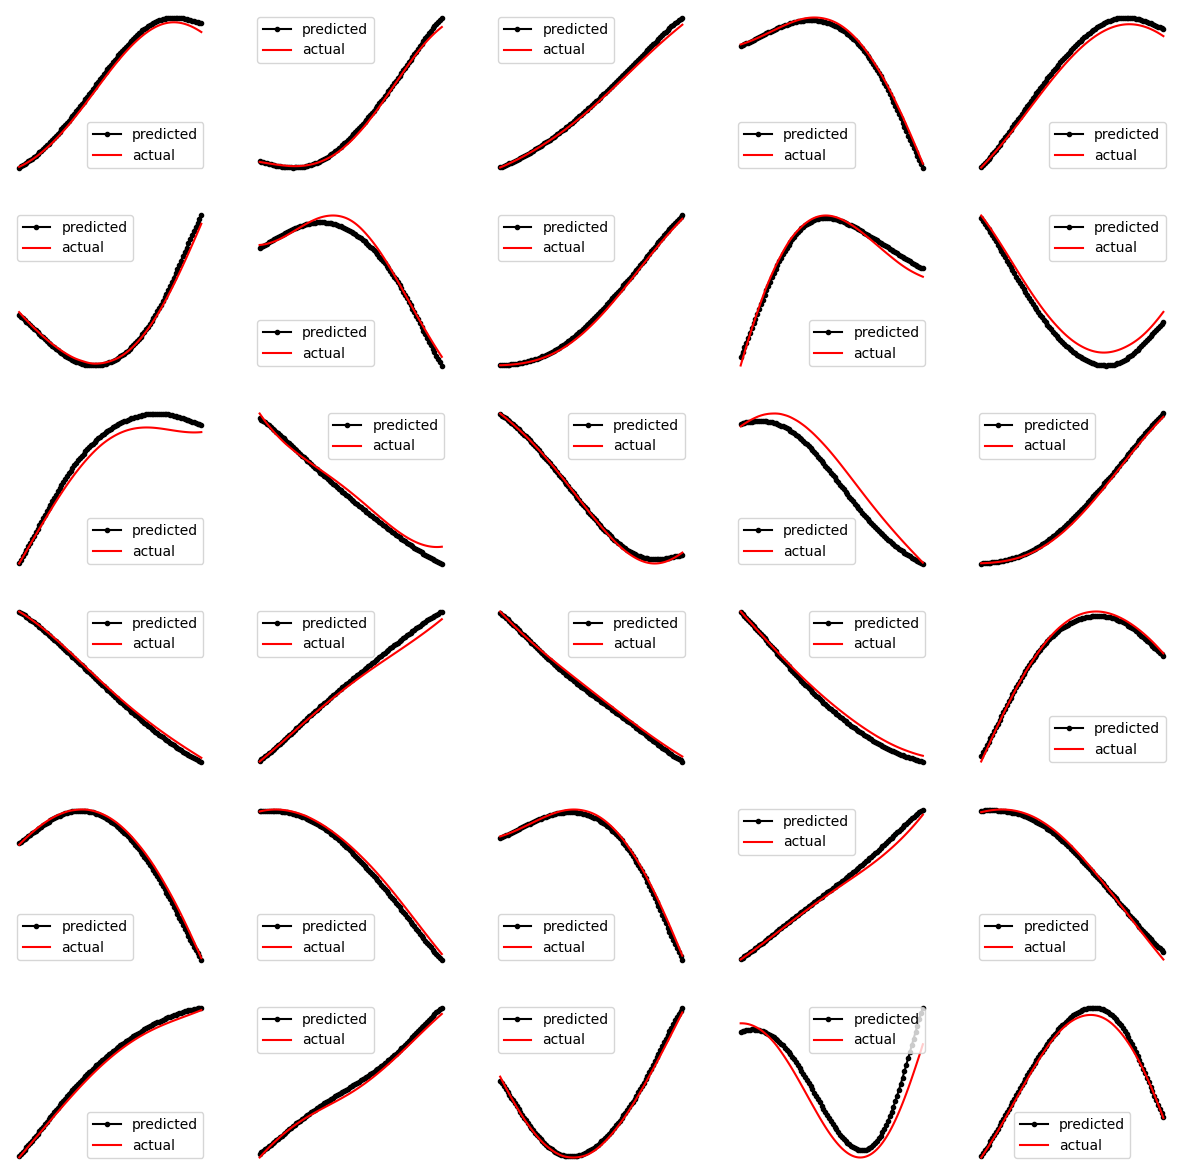

In [13]:
fig = plt.figure(figsize=(15,15))
for i in range(30):  
    r = np.random.choice(1000)
    ax = fig.add_subplot(6, 5, i+1)
    ax.plot(x,s_pred[r] , c = 'black', marker='.',label="predicted")  
    ax.plot(x,s_test[r] ,c='r',label="actual")
    plt.legend()
    plt.axis('off')
    

Sometimes we refer to situation as part of 2 variable x and y and hence plot is viewed in that case like:

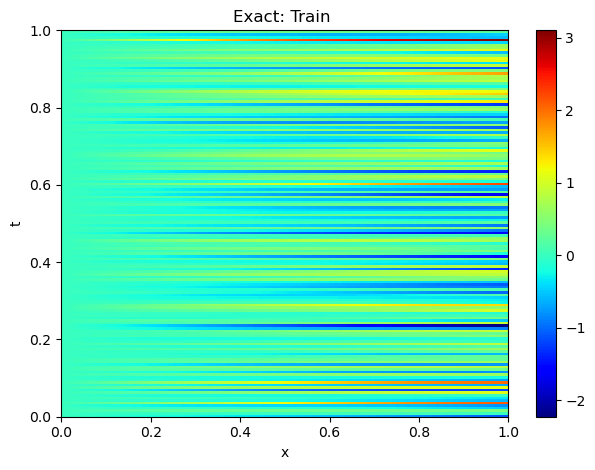

In [14]:
t = np.linspace(0, 1, 101)
x = np.linspace(0, 1, 151)
T, X = np.meshgrid(t, x)
plt.pcolor(T, X, s_train, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact: Train ')
plt.colorbar()
plt.tight_layout()

(151, 101) (151,) (100,)


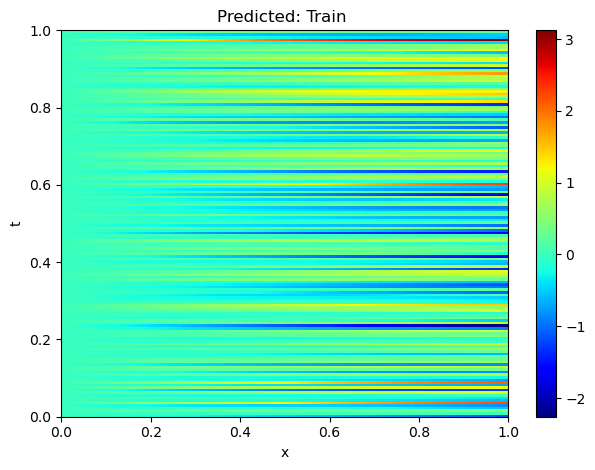

In [15]:
print(T.shape,x.shape,s_train[0].shape)
plt.pcolor(T, X, s_pred_train, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted: Train ')
plt.colorbar()
plt.tight_layout()

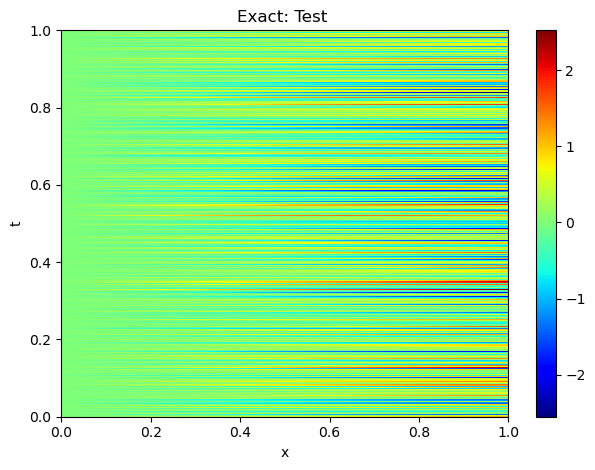

In [16]:
t = np.linspace(0, 1, 101)
x = np.linspace(0, 1, 1001)
T, X = np.meshgrid(t, x)
plt.pcolor(T, X, s_test, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact: Test ')
plt.colorbar()
plt.tight_layout()

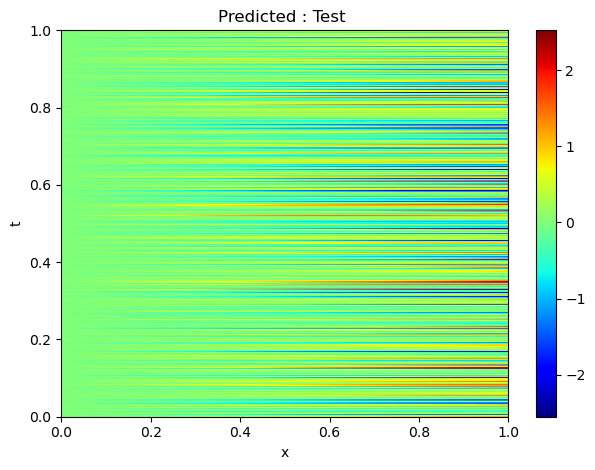

In [17]:
plt.pcolor(T, X, s_test, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted : Test ')
plt.colorbar()
plt.tight_layout()